In [1]:
import json
import numpy as np
import imageio
import pdb
from pathlib import Path
import cv2
from PIL import Image

# @markdown The base directory for all captures. This can be anything if you're running this notebook on your own Jupyter runtime.
save_dir = './data/'  
capture_name = 'nvidia/Balloon1-2' 
# The root directory for this capture.
root_dir = Path(save_dir, capture_name)
# Where to save RGB images.
rgb_dir = root_dir / 'rgb'
rgb_raw_dir = root_dir / 'rgb-raw'
# Where to save mask images.
mask_dir = root_dir / 'mask'
mask_raw_dir = root_dir / 'mask-raw'
camera_gt_dir = root_dir / 'camera-gt'
camera_test_gt_dir = root_dir / 'camera-paths-gt' / 'orbit-mild'

camera_gt_dir.mkdir(exist_ok=True, parents=True)
camera_test_gt_dir.mkdir(exist_ok=True, parents=True)

# make dirs for freeze test if available
freeze_test_dir = root_dir / 'freeze-test'
if freeze_test_dir.exists():
    rgb_raw_freeze_test_dir = freeze_test_dir / 'rgb-raw'
    rgb_freeze_test_dir = freeze_test_dir / 'rgb'
    cam_freeze_test_dir = freeze_test_dir / 'camera-gt'

    rgb_freeze_test_dir.mkdir(exist_ok=True, parents=True)
    cam_freeze_test_dir.mkdir(exist_ok=True, parents=True)

    with open(freeze_test_dir / 'metadata_kubric.json','r') as f:
            k_freeze_meta = json.load(f)

with open(root_dir / 'metadata_kubric.json','r') as f:
    k_meta = json.load(f)

tmp_rgb_raw_dir = rgb_raw_dir

rgb_list = list(sorted(rgb_raw_dir.glob( '*.png')))
image_size = imageio.imread(rgb_list[0]).shape[:2]
rgb_list[:3]


FileNotFoundError: [Errno 2] No such file or directory: 'data/nvidia/Balloon1-2/metadata_kubric.json'

In [3]:
# @title Resize images into different scales.
# @markdown Here we save the input images at various resolutions (downsample by a factor of 1, 2, 4, 8). We use area relation interpolation to prevent moire artifacts.


def save_image(path, image: np.ndarray) -> None:
  print(f'Saving {path}')
  if not path.parent.exists():
    path.parent.mkdir(exist_ok=True, parents=True)
  with path.open('wb') as f:
    image = Image.fromarray(np.asarray(image))
    image.save(f, format=path.suffix.lstrip('.'))


def image_to_uint8(image: np.ndarray) -> np.ndarray:
  """Convert the image to a uint8 array."""
  if image.dtype == np.uint8:
    return image
  if not issubclass(image.dtype.type, np.floating):
    raise ValueError(
        f'Input image should be a floating type but is of type {image.dtype!r}')
  return (image * 255).clip(0.0, 255).astype(np.uint8)


def make_divisible(image: np.ndarray, divisor: int) -> np.ndarray:
  """Trim the image if not divisible by the divisor."""
  height, width = image.shape[:2]
  if height % divisor == 0 and width % divisor == 0:
    return image

  new_height = height - height % divisor
  new_width = width - width % divisor

  return image[:new_height, :new_width]


def downsample_image(image: np.ndarray, scale: int) -> np.ndarray:
  """Downsamples the image by an integer factor to prevent artifacts."""
  if scale == 1:
    return image

  height, width = image.shape[:2]
  if height % scale > 0 or width % scale > 0:
    raise ValueError(f'Image shape ({height},{width}) must be divisible by the'
                     f' scale ({scale}).')
  out_height, out_width = height // scale, width // scale
  resized = cv2.resize(image, (out_width, out_height), cv2.INTER_AREA)
  return resized



image_scales = "1,2,4"  # @param {type: "string"}
image_scales = [int(x) for x in image_scales.split(',')]

for image_path in Path(tmp_rgb_raw_dir).glob('*.png'):
  image = make_divisible(imageio.imread(image_path), max(image_scales))
  for scale in image_scales:
    save_image(
        rgb_dir / f'{scale}x/{image_path.stem}.png',
        image_to_uint8(downsample_image(image, scale)))

if mask_raw_dir.exists():
    for mask_path in Path(mask_raw_dir).glob('*.png'):
      mask = make_divisible(imageio.imread(mask_path), max(image_scales))
      for scale in image_scales:
        save_image(
            mask_dir / f"{scale}x/{mask_path.stem.replace('segmentation','rgba')}.png",
            image_to_uint8(downsample_image(mask, scale)))


if freeze_test_dir.exists():
    for rgb_path in Path(rgb_raw_freeze_test_dir).glob('*.png'):
      image = make_divisible(imageio.imread(rgb_path), max(image_scales))
      for scale in image_scales:
        save_image(
            rgb_freeze_test_dir / f"{scale}x/{rgb_path.stem}.png",
            image_to_uint8(downsample_image(image, scale)))


Saving data/kubric_bag/rgb/1x/rgba_00191.png
Saving data/kubric_bag/rgb/2x/rgba_00191.png
Saving data/kubric_bag/rgb/4x/rgba_00191.png
Saving data/kubric_bag/rgb/1x/rgba_00136.png
Saving data/kubric_bag/rgb/2x/rgba_00136.png
Saving data/kubric_bag/rgb/4x/rgba_00136.png
Saving data/kubric_bag/rgb/1x/rgba_00051.png
Saving data/kubric_bag/rgb/2x/rgba_00051.png
Saving data/kubric_bag/rgb/4x/rgba_00051.png
Saving data/kubric_bag/rgb/1x/rgba_00128.png
Saving data/kubric_bag/rgb/2x/rgba_00128.png
Saving data/kubric_bag/rgb/4x/rgba_00128.png
Saving data/kubric_bag/rgb/1x/rgba_00055.png
Saving data/kubric_bag/rgb/2x/rgba_00055.png
Saving data/kubric_bag/rgb/4x/rgba_00055.png
Saving data/kubric_bag/rgb/1x/rgba_00178.png
Saving data/kubric_bag/rgb/2x/rgba_00178.png
Saving data/kubric_bag/rgb/4x/rgba_00178.png
Saving data/kubric_bag/rgb/1x/rgba_00058.png
Saving data/kubric_bag/rgb/2x/rgba_00058.png
Saving data/kubric_bag/rgb/4x/rgba_00058.png
Saving data/kubric_bag/rgb/1x/rgba_00096.png
Saving dat

Check the generated image:

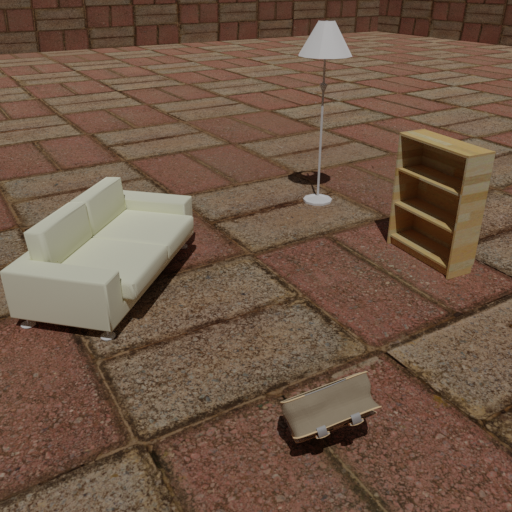

In [4]:
image_paths = list((rgb_dir / '1x').iterdir())
Image.open(image_paths[0])

## Write ground truth camera

In [5]:
from scipy.spatial.transform import Rotation as R

cameras = []

for i, rgb in enumerate(rgb_list):
    meta = {}
    quat = k_meta['camera']['quaternions'][i]
    # change quaternion format from [w,x,y,z] to [x,y,z,w]
    quat = [quat[1],quat[2],quat[3],quat[0]]
    rot = R.from_quat(quat)
    # orientation is the world to camera rotation matrix!!!
    matrix = rot.as_matrix()
    # rotate camera -- seems to be needed for some reason
    matrix = matrix @ np.array([[ 1, 0, 0],
                                [ 0,-1, 0],
                                [ 0, 0,-1]])
    meta['orientation'] = matrix.T.tolist()
    meta['position'] = k_meta['camera']['positions'][i]
    meta['focal_length'] = k_meta['camera']['focal_length'] * image_size[0] / k_meta['camera']['sensor_width']  # k_meta['camera']['focal_length']  # 428.4225158691406  
    meta['principal_point'] = [image_size[0]/2, image_size[1]/2] # check
    meta['skew'] = 0.
    meta['pixel_aspect_ratio'] = 1. # check
    meta['radial_distortion'] = [0., 0., 0.] # check
    meta['tangential_distortion'] = [0., 0.] # check
    meta['image_size'] = image_size
    cameras.append(meta)

    with open(str(camera_gt_dir / rgb.stem) + '.json', 'w') as f:
        json.dump(meta, f, indent=2)

# write freeze test cameras
if freeze_test_dir.exists():
    for i, rgb in enumerate(list(sorted(rgb_raw_freeze_test_dir.glob('*.png')))):
        meta = {}
        quat = k_freeze_meta['camera']['quaternions'][i]
        # change quaternion format from [w,x,y,z] to [x,y,z,w]
        quat = [quat[1],quat[2],quat[3],quat[0]]
        rot = R.from_quat(quat)
        matrix = rot.as_matrix()
        # rotate camera -- seems to be needed for some reason
        matrix = matrix @ np.array([[ 1, 0, 0],
                                    [ 0,-1, 0],
                                    [ 0, 0,-1]])
        meta['orientation'] = matrix.T.tolist()
        meta['position'] = k_freeze_meta['camera']['positions'][i]
        meta['focal_length'] = k_freeze_meta['camera']['focal_length'] * image_size[0] / k_freeze_meta['camera']['sensor_width'] 
        meta['principal_point'] = [image_size[0]/2, image_size[1]/2] # check
        meta['skew'] = 0.
        meta['pixel_aspect_ratio'] = 1. # check
        meta['radial_distortion'] = [0., 0., 0.] # check
        meta['tangential_distortion'] = [0., 0.] # check
        meta['image_size'] = image_size

        with open(str(cam_freeze_test_dir / rgb.stem) + '.json', 'w') as f:
            json.dump(meta, f, indent=2)

# Write test camera

In [6]:
from hypernerf import camera as camera_model
# compute center point of all cameras
positions = np.array([cam['position'] for cam in cameras])
center = np.average(positions, axis=0)
center_axis = (0. - center) / np.linalg.norm(center)
axis_2 = center_axis.copy()
axis_2[0] += 1
axis_a = np.cross(center_axis, axis_2)
axis_a = axis_a / np.linalg.norm(axis_a)
axis_b = np.cross(center_axis, axis_a)
axis_b = axis_b / np.linalg.norm(axis_b)

# radius ratio decides the circle radius of test camera
RADIUS_RATIO = 0.5
N_TEST = 100

dists = []
for cam in cameras:
    dists.append(np.sqrt(np.sum((np.array(cam['position']) - center) ** 2)))
mean_dist = np.average(dists)
radius = mean_dist * RADIUS_RATIO
print(f'radius: {radius}')

angles = np.linspace(0, 2 * np.pi, N_TEST)
for i, ang in enumerate(angles):  
    new_pos = center + radius * np.cos(ang) * axis_a + radius * np.sin(ang) * axis_b

    test_cam = camera_model.Camera.from_json(str(camera_gt_dir / rgb_list[0].stem) + '.json')
    test_cam.position = new_pos
    test_cam.look_at(new_pos, np.array([0,0,0]), np.array([1,0,0]))

    with open(str(camera_test_gt_dir / f'{i:06d}.json'), 'w') as f:
        json.dump(test_cam.to_json(), f, indent=2)


2022-04-13 08:54:46.588806: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/software/spack/spack-0.11.2/opt/spack/linux-rhel7-x86_64/gcc-5.4.0/openmpi-1.10.7-jdc7f4fjdq5roxhadufd6h66xkwuytss/lib:/usr/local/software/spack/spack-0.11.2/opt/spack/linux-rhel7-x86_64/gcc-4.8.5/gcc-5.4.0-fis24ggupugiobii56fesif2y3qulpdr/lib64:/usr/local/software/spack/spack-0.11.2/opt/spack/linux-rhel7-x86_64/gcc-4.8.5/gcc-5.4.0-fis24ggupugiobii56fesif2y3qulpdr/lib:/usr/local/Cluster-Apps/cuda/8.0/lib64:/usr/local/Cluster-Apps/cuda/8.0/lib:/usr/local/software/global/lib:/usr/local/Cluster-Apps/vgl/2.5.1/64/lib:/usr/local/software/slurm/current/lib
2022-04-13 08:54:46.588858: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


radius: 0.8787042304463328


## Write dataset split

In [7]:
# @title Save dataset split to `dataset.json`.

VAL_RATIO = 0

all_ids = list(map(lambda x: x.stem,rgb_list))
val_ids = all_ids[::int(1 / VAL_RATIO)] if VAL_RATIO > 0 else []
train_ids = sorted(set(all_ids) - set(val_ids))

print(f'Num of train: {len(train_ids)}')
print(f'Num of val: {len(val_ids)}')

dataset_json = {
    'count': len(all_ids),
    'num_exemplars': len(train_ids),
    'ids': all_ids,
    'train_ids': train_ids,
    'val_ids': val_ids,
}

dataset_json_path = root_dir / 'dataset.json'
with dataset_json_path.open('w') as f:
    json.dump(dataset_json, f, indent=2)

print(f'Saved dataset information to {dataset_json_path}')

# write meta info for freeze test if exists
if freeze_test_dir.exists():
    all_ids_freeze_test = [img.stem for img in list(sorted(rgb_raw_freeze_test_dir.glob('*.png')))]
    train_ids_freeze_test = []
    val_ids_freeze_test = all_ids_freeze_test
    dataset_json = {
        'count': len(all_ids_freeze_test),
        'num_exemplars': len(train_ids_freeze_test),
        'ids': all_ids_freeze_test,
        'train_ids': train_ids_freeze_test,
        'val_ids': val_ids_freeze_test,
    }

    dataset_json_path = freeze_test_dir / 'dataset.json'
    with dataset_json_path.open('w') as f:
        json.dump(dataset_json, f, indent=2)

Num of train: 200
Num of val: 0
Saved dataset information to data/kubric_bag/dataset.json


## Save metadata info

In [8]:
# @title Save metadata information to `metadata.json`.
import bisect

metadata_json = {}
for i, image_id in enumerate(train_ids):
  metadata_json[image_id] = {
      'warp_id': i,
      'appearance_id': i,
      'camera_id': 0,
  }
for i, image_id in enumerate(val_ids):
  i = bisect.bisect_left(train_ids, image_id)
  metadata_json[image_id] = {
      'warp_id': i,
      'appearance_id': i,
      'camera_id': 0,
  }

metadata_json_path = root_dir / 'metadata.json'
with metadata_json_path.open('w') as f:
    json.dump(metadata_json, f, indent=2)

print(f'Saved metadata information to {metadata_json_path}')


# write meta info for freeze test if exists
if freeze_test_dir.exists():
  freeze_frame = metadata_json[list(sorted(rgb_raw_freeze_test_dir.glob('*.png')))[k_freeze_meta['test_freeze_frame'] - 1].stem]
  # freeze_frame = metadata_json[list(sorted(rgb_raw_freeze_test_dir.glob('*.png')))[k_freeze_meta['test_freeze_frame']].stem]

  metadata_freeze_json = {}
  for i, image_path in enumerate(list(sorted(rgb_raw_freeze_test_dir.glob('*.png')))):
    image_id = image_path.stem
    metadata_freeze_json[image_id] = freeze_frame

  metadata_json_path = freeze_test_dir / 'metadata.json'
  with metadata_json_path.open('w') as f:
      json.dump(metadata_freeze_json, f, indent=2)

  print(f'Saved freeze metadata information to {metadata_json_path}')


Saved metadata information to data/kubric_bag/metadata.json
Saved freeze metadata information to data/kubric_bag/freeze-test/metadata.json


## Write scene info

In [9]:
def get_bbox_corners(points):
  lower = points.min(axis=0)
  upper = points.max(axis=0)
  return np.stack([lower, upper])

bbox_corners = get_bbox_corners(np.array(k_meta['instances'][0]['bboxes_3d'])[0])
bbox_corners = np.array([[0,   0,  0],
                         [50, 50, 10]])

# scene_center = np.mean(bbox_corners, axis=0)
scene_scale = 1.0 / np.sqrt(np.sum((bbox_corners[1] - bbox_corners[0]) ** 2))
scene_center = np.array([0., 0., 0.])
# scene_scale = 0.01

print(f'Scene Center: {scene_center}')
print(f'Scene Scale: {scene_scale}')

# @title Save scene information to `scene.json`.

scene_json_path = root_dir /  'scene_gt.json'
with scene_json_path.open('w') as f:
  json.dump({
      'scale': scene_scale,
      'center': scene_center.tolist(),
      'bbox': bbox_corners.tolist(),
      'near': 0.1,
      'far': 1. # bbox_corners[1].max() * scene_scale,
  }, f, indent=2)

print(f'Saved scene information to {scene_json_path}')

Scene Center: [0. 0. 0.]
Scene Scale: 0.0140028008402801
Saved scene information to data/kubric_bag/scene_gt.json
